In [1]:
#데이터 분석 라이브러리
import numpy as np
print("numpy version: {}". format(np.__version__))

import pandas as pd

#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))


#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.rcParams["legend.framealpha"]= 0.5 # legend 투명도


#딥러닝 라이브러리
import tensorflow as tf

#기타 라이브러리
import os
import random
import time

#경고 에러 무시
import warnings
warnings.filterwarnings('ignore')
print('-'*50)

#시간 확인을 용이하게 해주는 라이브러리
from tqdm import tqdm

#결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from varname import nameof

numpy version: 1.19.5
matplotlib version: 3.4.2
seaborn version: 0.11.1
--------------------------------------------------


# GPU

In [2]:
#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# absum 설명

(feature (item)별) absum 그래프를 위해 필요한 것들: <br>
<span style = 'color: red'>그래프를 1의 비율로 그림</span> <br>
<span style = 'color: red'>입력은 top10 feature list</span> <br>

1. x, y data load <br><br>

2. [생존사망 분리] (그림판 하나에 2개의 라인그래프) <br>
    2-1. y로 사망 or 생존 나눠서 <br>
    2-2. x_사망, x_생존 따로 따로 받아놓기 <br><br>

3. 각 x_사망, x_생존을 ~~item~~ <span style = 'color: red'>환자</span> 별로 sum <br>
    3-1. x shape: (환자수, time(10), item(4068)); ~~환자, time 방향으로 찍어눌러서 sum~~ ~~환자, item방향으로~~ <span style = 'color: red'>only 환자 방향으로만</span> sum <br>
    최종 shape이 ~~(4068,1)~~ ~~(10,1)~~ <span style = 'color: red'>(10,4068)</span>이 되게끔. <br><br>

4. 입력으로 받은 feature의 idx로 x_사망, x_생존에서 위치 찾기 <br>
    4-1. feature 순서대로 정렬돼있는 feature list 필요함. <br>
    4-2. feature list에서 list.index(item)써서 idx를 찾거나 <br>
    list를 array로 바꿔서 np.where(arr == item) 로 idx를 찾거나해서 <br>
    x_사망, x_생존에서 찾아주면 됨. <br>
    
    ***애초에 list가 아닌 arr로 불려짐*** <br>
    ***x는 item대로 정렬돼있음.*** <br><br>

# :one: x, y data load

In [3]:
x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

# :two: 생존사망 분리
사망 = 1, 생존 = 0

## :two:-1 y로 사망 or 생존 나눠서

In [4]:
# x_사망, x_생존 뽑을 때 쓸 idx부터 생성
사망idx = np.where(y == 1)
생존idx = np.where(y == 0)

## :two:-2 x_사망, x_생존 따로따로 받아놓기

In [5]:
x_사망 = x[사망idx]
x_생존 = x[생존idx]

# :three: 각 x_사망, x_생존을 환자 방향으로만 sum 하고 1의 비율

In [6]:
# x_사망.sum(axis = 0).sum(axis = 1).sum() / (x_사망.shape[0] * x_사망.shape[2])
# x_생존.sum(axis = 0).sum(axis = 1).sum() / (x_생존.shape[0] * x_생존.shape[2])

# x_사망.sum(axis = 0).shape
# x_사망.sum(axis = 0) # 환자 방향 sum

x_사망_1ratio = x_사망.sum(axis = 0) / x_사망.shape[0]
x_생존_1ratio = x_생존.sum(axis = 0) / x_생존.shape[0]

# :four: 입력받은 feature의 idx로 x_사망, x_생존에서 위치 찾기
feat_lst는 total_data_7727에서 찾을 수 있음.

In [7]:
feature = pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].unique()
feat_arr = np.sort(feature)
# https://rfriend.tistory.com/357 # numpy sorting

In [8]:
feat_arr

array([          0,       50803,       50804, ..., 87701071218,
       87701083336, 87701089415])

In [9]:
# x_사망[np.where(feat_arr == 51277)]
# x_생존[np.where(feat_arr == 51277)]
############################################위는 틀린 방식;;;

np.where(feat_arr == 51277)
x_사망_1ratio.shape

x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()
x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()

np.max(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten())

(array([206]),)

(10, 4068)

array([0.29652395, 0.32153455, 0.34866469, 0.37303942, 0.40440865,
       0.4296312 , 0.45633743, 0.46799491, 0.46820687, 0.46015261])

array([0.16218013, 0.17048853, 0.18743769, 0.21036889, 0.2259887 ,
       0.24194084, 0.26886009, 0.2745098 , 0.26819541, 0.26321037])

0.4682068673166596

# subplot test

In [91]:
x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten().argmax()

8

(0.0, 0.8785502331496396)

(0.0, 0.9102691924227319)

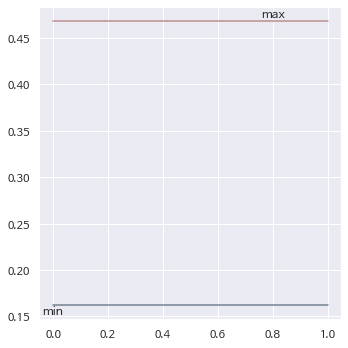

In [89]:
# ylim
x_사망_1ratio.min(), x_사망_1ratio.max()
x_생존_1ratio.min(), x_생존_1ratio.max()

fig = plt.figure(figsize = (5,5))
ax = plt.subplot()

# 최대 최소 값 지정
_ = ax.plot([(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max(), (x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max()], color = 'rosybrown')
_ = ax.plot([(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min(), (x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min()], color = 'slategrey')

# _ = ax.set_ylim([0,0.5])
# _ = ax.set_xlim([0,10])

_ = ax.text(x_사망_1ratio[:,np.where(feat_arr == 51277)].argmax() / 10,(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max(), 'max', verticalalignment = 'bottom', horizontalalignment = 'center')
_ = ax.text(x_생존_1ratio[:,np.where(feat_arr == 51277)].argmin(),(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min(), 'min', verticalalignment = 'top', horizontalalignment = 'center')

plt.tight_layout()

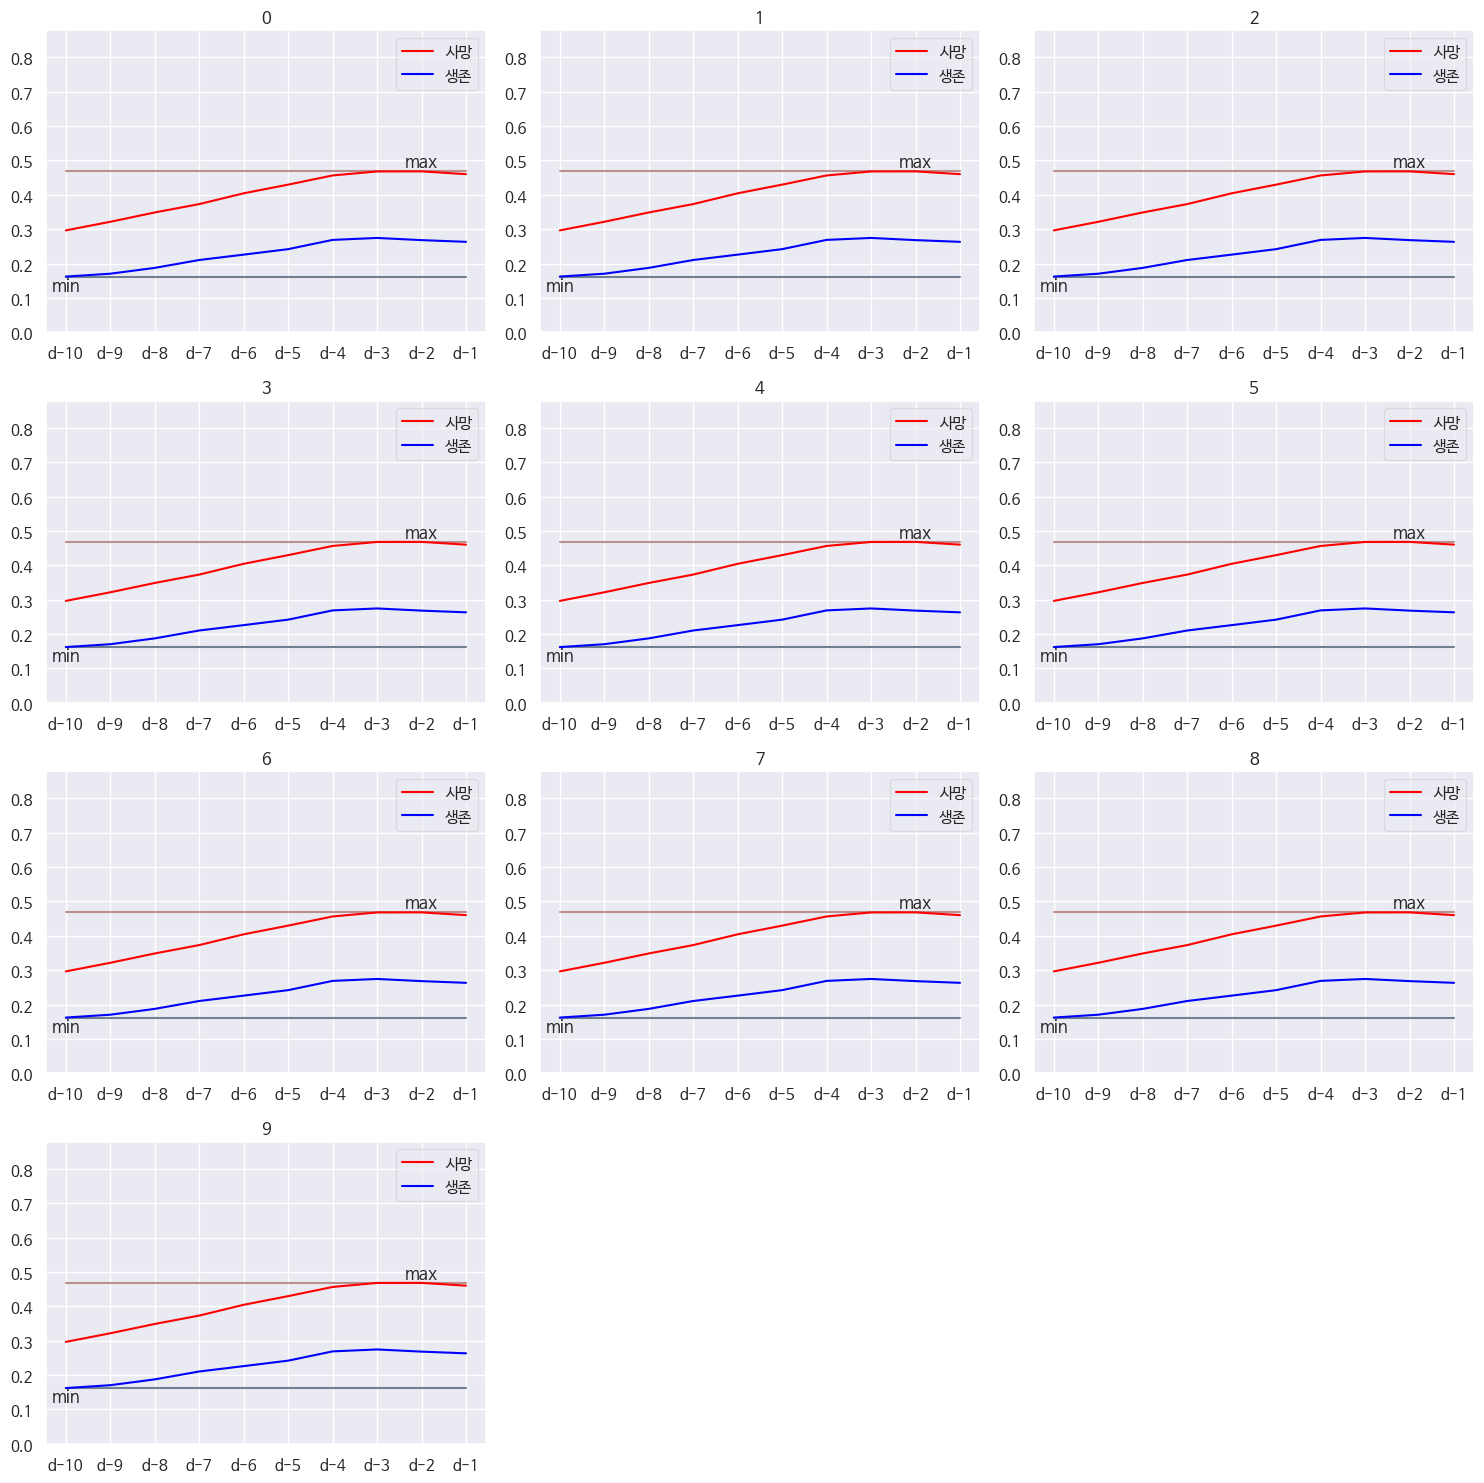

In [90]:
fig = plt.figure(figsize = (15,15), dpi = 100) # 도화지 생성
rows = 4
cols = 3

plt.rcParams["legend.framealpha"]= 0.5
# https://kongdols-room.tistory.com/89 # legend 투명도

# # axes index 방법
# ax_idx = []
# for r in range(rows):
#     for c in range(cols):
#         ax_idx.append([r,c])

# fig.add_subplot(rows, cols, python_idx+1) 방법 # https://artiiicy.tistory.com/64
# for k in range(rows*cols): # 함수 안에서는 feat_top_10의 len으로 할 것. 또는 이중 for loop 머리아프니까 함수에 이미 있는 for문에 enumerate 씌우고,,, figure는 for문 밖으로 빼고 아래만 쓸 것.
for k in range(10):
    ax = fig.add_subplot(rows, cols, k+1)
    _ = ax.set_title(f'{k}') # 함수 안에서는 item name으로 해줄 것.
    
    # 최대 최소 값 지정
    _ = ax.plot([0,9],[(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max(), (x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max()], color = 'rosybrown')
    _ = ax.plot([0,9],[(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min(), (x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min()], color = 'slategrey')

    plot1, = ax.plot(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten(), label = '사망', color = 'red')
    plot2, = ax.plot(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten(), label = '생존', color = 'blue')
    
    # 최대 최소 text
    _ = ax.text(x_사망_1ratio[:,np.where(feat_arr == 51277)].argmax(),(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten()).max(), 'max', verticalalignment = 'bottom', horizontalalignment = 'center')
    _ = ax.text(x_생존_1ratio[:,np.where(feat_arr == 51277)].argmin(),(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten()).min(), 'min', verticalalignment = 'top', horizontalalignment = 'center')

#     _ = ax.set_ylim([(np.min(x_생존_1ratio[:,np.where(feat_arr == 51277)].flatten())-0.05), (np.max(x_사망_1ratio[:,np.where(feat_arr == 51277)].flatten())+0.05)])
    _ = ax.set_ylim([x_생존_1ratio.min(), x_사망_1ratio.max()]) # ylim 통일
#     _ = ax.set_xlim([-9,20])
    _ = ax.set_xticks(range(10))
    _ = ax.set_xticklabels([f'd-{d}' for d in range(10,0,-1)]) # 이상함;; ==> 220307 해결! by setting xticks
    _ = ax.legend('best', handles = [plot1, plot2])

# matplotlib 축 범위 지정
# https://codetorial.net/matplotlib/axis_range.html

# ax.plot label 설정
# https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.axes.Axes.legend.html

plt.tight_layout()

In [99]:
# for i in range(10,1,-1):
#     i
[f'd-{d}' for d in range(10,0,-1)]

['d-10', 'd-9', 'd-8', 'd-7', 'd-6', 'd-5', 'd-4', 'd-3', 'd-2', 'd-1']

# absum 함수

In [116]:
def absum(feat_top_10):
    # 1. x, y data load
    x = np.load('/project/LSH/x_(7727,10,4068).npy')
    y = np.load('/project/LSH/y_(7727,1).npy')

    # 2. 생존사망 분리
#     사망 = 1, 생존 = 0

    ## 2-1 y로 사망 or 생존 나눠서
    # x_사망, x_생존 뽑을 때 쓸 idx부터 생성
    사망idx = np.where(y == 1)
    생존idx = np.where(y == 0)

    ## 2-2 x_사망, x_생존 따로따로 받아놓기
    x_사망 = x[사망idx]
    x_생존 = x[생존idx]

    # 3. 각 x_사망, x_생존을 환자 방향으로만 sum 하고 1의 비율
    x_사망_1ratio = x_사망.sum(axis = 0) / x_사망.shape[0]
    x_생존_1ratio = x_생존.sum(axis = 0) / x_생존.shape[0]

    # 4. 입력받은 feature의 idx로 x_사망, x_생존에서 위치 찾기
    # feat_lst는 total_data_7727에서 찾을 수 있음.
    feature = pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].unique()
    feat_arr = np.sort(feature)
    
    
    # 5. 그래프
    fig = plt.figure(figsize = (15,15), dpi = 100) # 도화지 생성
    rows = 4
    cols = 3
    
    for idx,i in enumerate(feat_top_10):
        
        feat_사망 = x_사망_1ratio[:,np.where(feat_arr == i)].flatten()
        feat_생존 = x_생존_1ratio[:,np.where(feat_arr == i)].flatten()

        # fig.add_subplot(rows, cols, python_idx+1) 방법
        ax = fig.add_subplot(rows, cols, idx+1)
        
        # 최대 최소 값 지정
#         _ = ax.plot([0,9],[feat_사망.max(), feat_사망.max()], color = 'rosybrown', linestyle = '--')
#         _ = ax.plot([0,9],[feat_생존.min(), feat_생존.min()], color = 'slategrey', linestyle = '--')
                
        
        # 그래프
        plot1, = ax.plot(feat_사망, label = '사망', color = 'red')
        plot2, = ax.plot(feat_생존, label = '생존', color = 'blue')
        
        # 마커, text찍기
        # 마커; https://jiwoncho20213135python.tistory.com/11
        # 소수점; https://blockdmask.tistory.com/534
        if feat_사망.max() >= feat_생존.max():
            _ = ax.plot([feat_사망.argmax(), feat_사망.argmax()], [feat_사망.max(), feat_사망.max()], marker = '8', color = 'red')
            _ = ax.text(feat_사망.argmax(),feat_사망.max(), f'max:{feat_사망.max():.2f}', verticalalignment = 'bottom', horizontalalignment = 'center', fontsize = 11)
        else:
            _ = ax.plot([feat_생존.argmax(), feat_생존.argmax()], [feat_생존.max(), feat_생존.max()], marker = '8', color = 'blue')
            _ = ax.text(feat_생존.argmax(),feat_생존.max(), f'max:{feat_생존.max():.2f}', verticalalignment = 'bottom', horizontalalignment = 'center', fontsize = 11)
        
        if feat_생존.min() <= feat_사망.min():
            _ = ax.plot([feat_생존.argmin(), feat_생존.argmin()], [feat_생존.min(), feat_생존.min()], marker = '8', color = 'blue')
            _ = ax.text(feat_생존.argmin(),feat_생존.min(), f'min:{feat_생존.min():.2f}', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 11)
        else:
            _ = ax.plot([feat_사망.argmin(), feat_사망.argmin()], [feat_사망.min(), feat_사망.min()], marker = '8', color = 'red')
            _ = ax.text(feat_사망.argmin(),feat_사망.min(), f'min:{feat_사망.min():.2f}', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 11)

        
        # 최대 최소 text
#         _ = ax.text(feat_사망.argmax(),feat_사망.max(), 'max', verticalalignment = 'bottom', horizontalalignment = 'center')
#         _ = ax.text(feat_생존.argmin(),feat_생존.min(), 'min', verticalalignment = 'top', horizontalalignment = 'center')
        
        _ = ax.set_title(f'{i}') # 함수 안에서는 item name으로 해줄 것.
        _ = ax.set_xticks(range(10))
        _ = ax.set_xticklabels([f'd-{d}' for d in range(10,0,-1)])
#         _ = ax.set_ylim(np.min(feat_생존)-0.05, np.max(feat_사망)+0.1) # 사망이 큰쪽이니까 max를 지정해야함.
        _ = ax.set_ylim([x_생존_1ratio.min(), x_사망_1ratio.max()]) # 전 그래프 ylim 통일
        _ = ax.legend(loc = 'best', handles = [plot1, plot2])
        
    plt.tight_layout()

In [93]:
m_ent_top10_df = pd.read_csv('final_Method1_entropy.csv').sort_values('method1_entropy', ascending = False)[:10]
m_ent_top10_df

,feature,method1_entropy
206,51277,0.078080
121,51006,0.075320
41,50893,0.037807
56,50912,0.036471
2148,409176230,0.032615
34,50882,0.032041
184,51244,0.028505
2340,536338101,0.026930
119,51003,0.024043
1733,173024256,0.022380


In [94]:
m_ent_top10 = m_ent_top10_df['feature'].values
m_ent_top10

array([    51277,     51006,     50893,     50912, 409176230,     50882,
           51244, 536338101,     51003, 173024256])

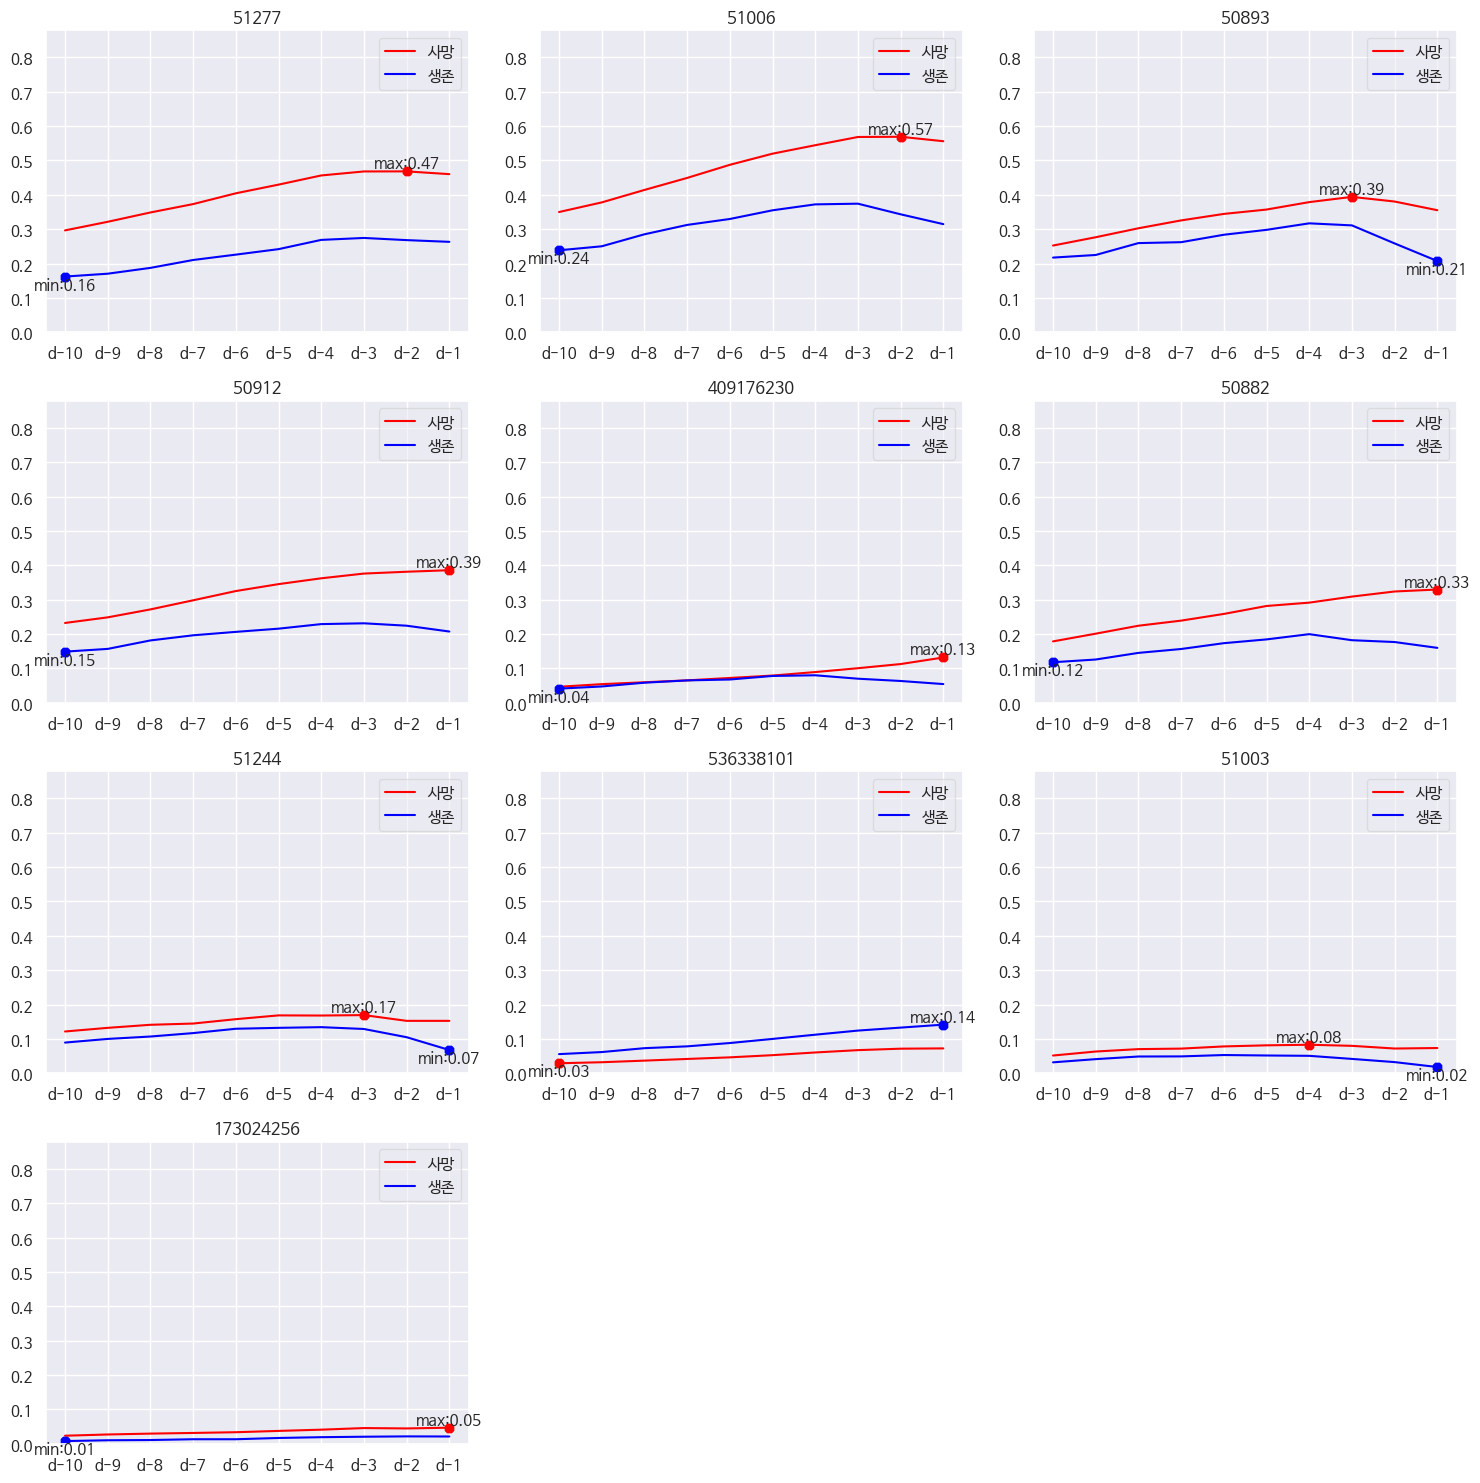

In [117]:
absum(m_ent_top10)